# Solution for the titanic problem

### Author: Bruno Martins

In [81]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import numpy as np

### Read the dataset

In [82]:
train_df = pd.read_csv('datasets/train.csv')

### Analyze some information about the columns

In [83]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Now, visualize the data for each of the classes

Information about the deceased

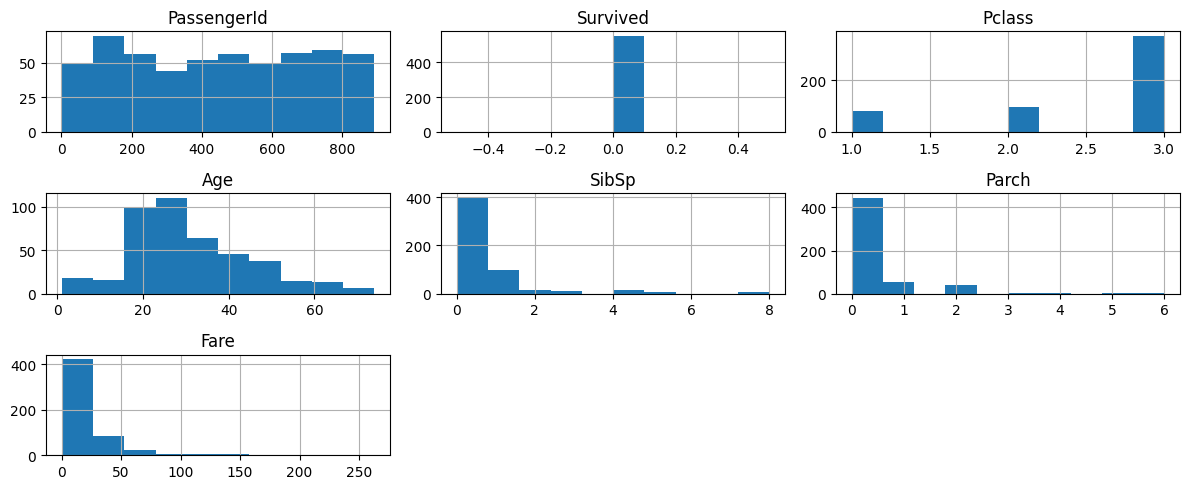

In [84]:
train_df[train_df['Survived'] == 0].hist(figsize=(12,5))
plt.tight_layout()

Information about the survivors

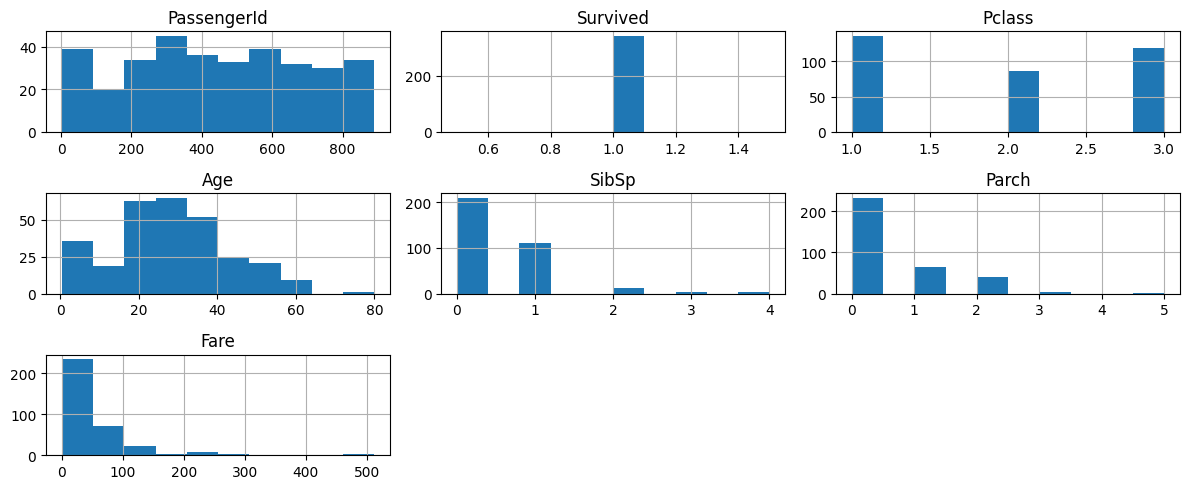

In [85]:
train_df[train_df['Survived'] == 1].hist(figsize=(12,5))
plt.tight_layout()

Plot the correlation matrix for the columns 

<AxesSubplot:>

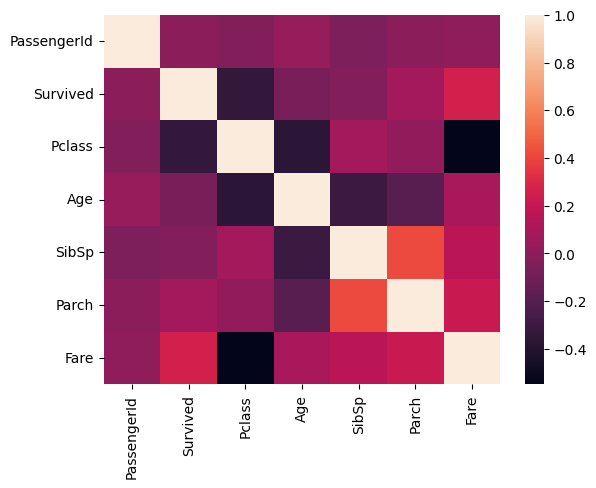

In [95]:
sns.heatmap(train_df.corr(), cmap='rocket')

### Drop some irrelavant features

In [22]:
train_df = train_df.drop('Name', axis=1)
train_df = train_df.drop('PassengerId', axis=1)
train_df = train_df.drop('Ticket', axis=1)
train_df = train_df.drop('Cabin', axis=1)

### Import the classes and methods from sklearn to apply the machine learning

In [23]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer

Read the test dataset

In [24]:
test_df = pd.read_csv('./datasets/test.csv')

In [25]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


### Drop irrelevant features

In [26]:
passenger_id = test_df['PassengerId'].values
test_df = test_df.drop('Name', axis=1)
test_df = test_df.drop('PassengerId', axis=1)
test_df = test_df.drop('Ticket', axis=1)
test_df = test_df.drop('Cabin', axis=1)

### Separate the feature matrix from the label vector

In [27]:
y = train_df.iloc[:, 0]
X = train_df.iloc[:, 1:]
X_test = test_df

### Builds a pipeline to deal with the data

In [47]:
# instantiates the scaler to be used. As described in the lecture, 
# MinMaxScaler is preferable over standardization when dealing with algorithms
# sensible to distance. In this case, we're planning to use KNN as a classifier
scaler = MinMaxScaler()
# imputers are needed to deal with missing values. In this case, we are replacing 
# by the median given the skewness of this feature's distribution
fare_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
# When it comes to categorical values, replacing missing values by the most 
# frequent one might be a good idea.
embarked_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# In the case of age, we're replacing by the mean
age_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# One hot encoder is needed to work with categorical features.
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
# Now, we instatiate the classifier.
classifier = KNeighborsClassifier()
# There are actually two categorical columns, but we're avoiding
# redudancy as it'll be seen later
categorical_columns = ['Sex']
# Again, there are more numerical columns
numerical_columns = ['Pclass', 'SibSp', 'Parch'] 

# This pipelines deal with missing values in the age column
# and also performs normalization. There's some 
# redundancy in the code because columnTransformer performs operations
# in parallel
age_pipe = Pipeline([
    ('fillmean', age_imputer),
    ('normalization', scaler),
])
# builds the pipe for the embarked. The encoder in the end means 
# it's a categorical value which should be encoded after dealing with nans
embarked_pipe = Pipeline([
    ('filltop', embarked_imputer),
    ('encoder', encoder),
])
# pipe for fare.
fare_pipe = Pipeline([
    ('fillmedian', fare_imputer),
    ('normalization', scaler)
])
# applies operations in parallel to the columns in the third value of each tuple
ct = ColumnTransformer([
    ('age', age_pipe, ['Age']),
    ('embarked', embarked_pipe, ['Embarked']),
    ('fare', fare_pipe, ['Fare']),
    ('encoder', encoder, categorical_columns),
    ('normalization', scaler, numerical_columns)]
)

### Evaluates the model for different sets of parameters using grid search

In [38]:
# parameters to be tested
knn_parameters = {'n_neighbors': [1, 3, 5, 9, 11], 'metric': ('euclidean', 'manhattan', 'minkowski')}
# grid search function
grid_clf = GridSearchCV(classifier, knn_parameters, cv=10, n_jobs=-1, refit=True)

grid_pipe = Pipeline([('transformer', ct), ('grid', grid_clf)])

_ = grid_pipe.fit(X,y)

### Output results for the given metrics, sorted by accuracy

In [56]:
results_df = pd.DataFrame(grid_clf.cv_results_)

results_df = results_df.sort_values('mean_test_score', ascending=False).reset_index()

results_df.head(2)

,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,6,0.002375,0.000293,0.008088,0.00121,manhattan,3,"{'metric': 'manhattan', 'n_neighbors': 3}",0.755556,0.842697,...,0.820225,0.853933,0.842697,0.831461,0.775281,0.842697,0.786517,0.809263,0.038859,1
1,7,0.002469,0.000231,0.009476,0.00131,manhattan,5,"{'metric': 'manhattan', 'n_neighbors': 5}",0.755556,0.808989,...,0.820225,0.876404,0.808989,0.842697,0.775281,0.853933,0.786517,0.807016,0.041024,2


### The obtained parameters can be extracted and used in the final classifier

In [67]:
n_neighbors = grid_clf.best_params_['n_neighbors']
distance = grid_clf.best_params_['metric']

### Classifier's parameters

In [68]:
classifier.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'manhattan',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 3,
 'p': 2,
 'weights': 'uniform'}

In [69]:
# set parametes for the classifier
classifier.set_params(metric = distance, n_neighbors = n_neighbors)
# performs columnTransformer and then feeds the data to the classifier
pipeline = Pipeline([('transformer', ct), ('classification', classifier)])
# Fit the model with the training data
model = pipeline.fit(X, y)
# Make predictions on the test set
y_predict = model.predict(X_test)

### Builds a DataFrame with the output

In [70]:
submission_data = pd.DataFrame({'PassengerId': passenger_id, 'Survived': y_predict})

Now, we save the result for later submission on kaggle

In [124]:
submission_data.to_csv('result.csv', index=False)